In [1]:
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
import gsd
import matplotlib.pyplot as plt
import numpy as np
import gsd.hoomd
from flowermd.base import Pack, Simulation
from flowermd.library import KremerGrestBeadSpring, LJChain
from flowermd.utils import get_target_box_number_density
from flowermd.base import Molecule
from flowermd.library import Graphene
from flowermd.library.forcefields import BeadSpring
from flowermd.base.forcefield import BaseHOOMDForcefield
import unyt as u
import hoomd
import mbuild as mb
import numpy as np
from cmeutils.visualize import FresnelGSD
cpu = hoomd.device.CPU()
import mbuild as mb
from mbuild.compound import Compound
from mbuild.lattice import Lattice
from flowermd.base import Molecule, System

## 2.1 Each simulation began by constructing a system of graphene flakes embedded in a polymer solution. Graphene() was used to generate the flake particles, with custom geometry reflective of C-C bond lengths. Each flake consists of carbons arranged in a 2D lattice to mimic the geometry of a MXene sheet.

In [2]:
class Graphene(System):
    def __init__(
        self,
        x_repeat,
        y_repeat,
        n_layers,
        base_units=dict(),
        periodicity=(True, True, False),
    ):
        surface = mb.Compound(periodicity=periodicity)
        scale = 0.246
        spacings = [s * scale for s in [1.0, 1.0, 1.0]]
        points = [[0, 0, 0], [2/3, 1/3, 0]]
        lattice = Lattice(
            lattice_spacing=spacings,
            angles=[90, 90, 120],
            lattice_points={"A": points},
        )
        carbon = Compound(name="C", element="C")
        layers = lattice.populate(
            compound_dict={"A": carbon}, x=x_repeat, y=y_repeat, z=n_layers
        )
        surface.add(layers)
        surface.freud_generate_bonds("C", "C", dmin=0.3*scale, dmax=0.6*scale)
        surface_mol = Molecule(num_mols=1, compound=surface)
        super(Graphene, self).__init__(
            molecules=[surface_mol],
            base_units=base_units,
        )

    def _build_system(self):
        return self.all_molecules[0]

In [3]:
def flake_distance_over_time(gsd_file, flake_size=50, dt=0.001):
    traj = gsd.hoomd.open(gsd_file)
    distances = []
    times = []

    for i, frame in enumerate(traj):
        pos = frame.particles.position
        types = frame.particles.types
        typeid = frame.particles.typeid
        carbon_type_id = types.index("C")
        flake_indices = np.where(typeid == carbon_type_id)[0]

        flake_positions = pos[flake_indices].reshape(-1, flake_size, 3)
        coms = flake_positions.mean(axis=1)

        dists = []
        for i in range(len(coms)):
            for j in range(i + 1, len(coms)):
                dists.append(np.linalg.norm(coms[i] - coms[j]))

        distances.append(np.mean(dists))
        times.append(frame.configuration.step * dt)

    return np.array(times), np.array(distances)

## 2.2 For interactions, the goal is to simulate entropy driven aggregation. To model purely entropic (depletion-driven) interactions, all nonbonded particle pairs—whether between monomers, between monomers and flakes, or between flakes themselves—interact via a Lennard-Jones potential truncated and shifted at a 2^1/2*sigma, eliminating the attractive tail of the potential, producing a WCA potential that is purely repulsive. This is to ensure that no attraction exists between anything. Therefore, any aggregation observed in the simulations must arise from entropic origins. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Autocorrelation function ----
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))
    acorr = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    dt = np.where(acorr < 1/np.e)[0][0]
    nsamples = len(array) // dt
    return acorr, dt, nsamples

system_sizes = [
    (2, 10)
]

results = {}
flake_distances = {}

for flake_num, chain_num in system_sizes:
    print(f"Running system with {flake_num} flakes and {chain_num} chains")
    kg_chain = LJChain(lengths=10, num_mols=chain_num)
    sheet = Graphene(x_repeat=5, y_repeat=5, n_layers=1, periodicity=(False, False, False))
    system = Pack(molecules=[Molecule(compound=sheet.all_molecules[0], num_mols=flake_num), kg_chain], density=0.0001)

    ff = BeadSpring(
        r_cut=2**(1/6) * 0.246,
        beads={
            "A": dict(epsilon=1.0, sigma=1.0 * 0.246),
            "C": dict(epsilon=1.0, sigma=1.0 * 0.246),
        },
        bonds={
            "C-C": dict(r0=0.57736 * 0.246, k=500),
            "A-A": dict(r0=1.0, k=500.0),
        },
        angles={
            "A-A-A": dict(t0=np.pi, k=10.0),
            "C-C-C": dict(t0=2 * np.pi / 3., k=500),
        },
        dihedrals={
            "A-A-A-A": dict(phi0=0.0, k=1.0, d=-1, n=1),
            "C-C-C-C": dict(phi0=0.1, k=0.1, d=-1, n=1),
        }
    )

    sim = Simulation(initial_state=system.hoomd_snapshot, forcefield=ff.hoomd_forces, device=cpu, dt=0.001, gsd_write_freq=1000, log_file_name=f"energy_{flake_num}_{chain_num}.txt")
    sim.run_NVT(n_steps=5000, kT=0.001, tau_kt=1.0)
    sim.run_NVT(n_steps=5e6, kT=2, tau_kt=0.1)
    sim.flush_writers()

    
    energy_data = np.genfromtxt(f"energy_{flake_num}_{chain_num}.txt", names=True, dtype=None, encoding="utf-8")
    pe = energy_data['mdcomputeThermodynamicQuantitiespotential_energy']

    acorr, dt, nsamples = autocorr1D(pe)
    print(f"Decorrel. time (1/e crossing): {dt} steps")
    print(f"# of Independent samples: {nsamples}")

    results[(flake_num, chain_num)] = dict(dt=dt, nsamples=nsamples)

    times, dists = flake_distance_over_time("trajectory.gsd", flake_size=50)
    flake_distances[(flake_num, chain_num)] = (times, dists)

Running system with 2 flakes and 10 chains
Initializing simulation state from a gsd.hoomd.Frame.
Step 1000 of 5000; TPS: 401.72; ETA: 0.2 minutes
Step 2000 of 5000; TPS: 787.17; ETA: 0.1 minutes
Step 3000 of 5000; TPS: 1156.6; ETA: 0.0 minutes
Step 4000 of 5000; TPS: 1510.84; ETA: 0.0 minutes
Step 0 of 5000000; TPS: 0.0; ETA: nan hours, nan minutes
Step 1000 of 5000000; TPS: 10851.05; ETA: 7.7 minutes
Step 2000 of 5000000; TPS: 10649.06; ETA: 7.8 minutes
Step 3000 of 5000000; TPS: 369.09; ETA: 3.0 hours, 46.0 minutes
Step 4000 of 5000000; TPS: 486.53; ETA: 2.0 hours, 51.0 minutes
Step 5000 of 5000000; TPS: 601.34; ETA: 2.0 hours, 18.0 minutes
Step 6000 of 5000000; TPS: 713.61; ETA: 1.0 hours, 57.0 minutes
Step 7000 of 5000000; TPS: 823.81; ETA: 1.0 hours, 41.0 minutes
Step 8000 of 5000000; TPS: 931.42; ETA: 1.0 hours, 29.0 minutes
Step 9000 of 5000000; TPS: 1036.81; ETA: 1.0 hours, 20.0 minutes
Step 10000 of 5000000; TPS: 1138.64; ETA: 1.0 hours, 13.0 minutes
Step 11000 of 5000000; TPS

## 2.3. First, the system was relaxed at a lower kT = 0.001, then was ramped up to kT = 2.0, in order to allow any potential overlaps to resolve without blowing up the system. Every run had identical decorrelation times, as well as the same amount of independent samples. 

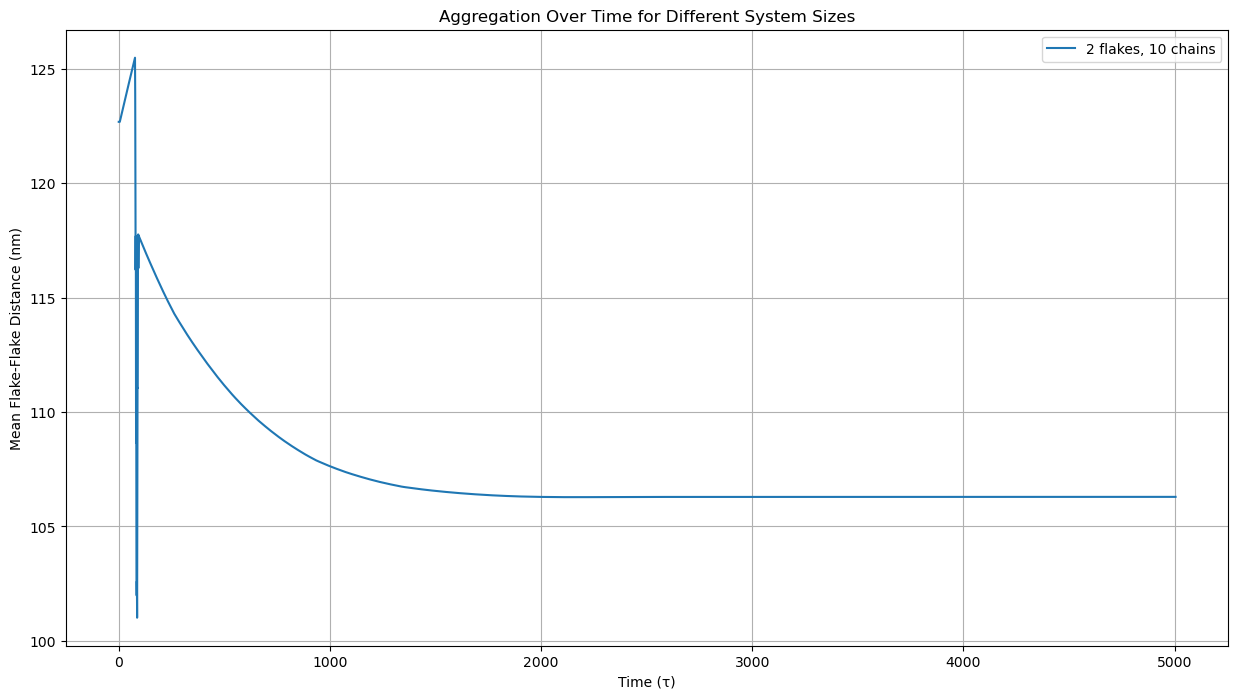


Summary of decorrelation times:
2 flakes, 10 chains → dt = 85 steps, nsamples = 58


In [7]:
plt.figure(figsize = (15,8))
for key, (times, dists) in flake_distances.items():
    flake_num, chain_num = key
    plt.plot(times, dists, label=f"{flake_num} flakes, {chain_num} chains")

plt.xlabel("Time (τ)")
plt.ylabel("Mean Flake-Flake Distance (nm)")
plt.title("Aggregation Over Time for Different System Sizes")
plt.legend()
plt.grid(True)
plt.show()

print("\nSummary of decorrelation times:")
for key, vals in results.items():
    f, c = key
    print(f"{f} flakes, {c} chains → dt = {vals['dt']} steps, nsamples = {vals['nsamples']}")

## 2.4. Smaller system sizes were used as a result of computing constraints, such as the VPN not allowing me to stay connected to it for very long. The lower the amount of polymers, the more aggregation over time occurs.